In [22]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import torchvision.transforms as transforms

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

<class 'torch.Tensor'>
torch.Size([3, 1080, 1920])


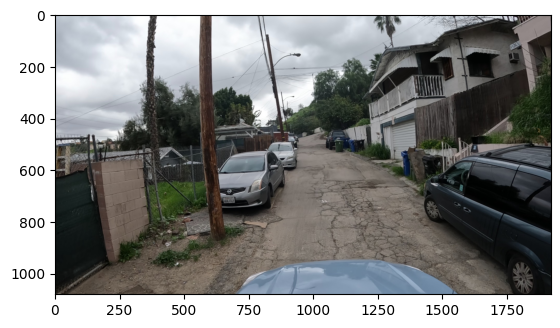

In [15]:
image_path = '/Volumes/JC SSD/SRILab Data/GoPro Frames/frame1037.0.jpg'

img = read_image(image_path)

plt.imshow(img.permute(1, 2, 0))

# Print type of img
print(type(img))

# Print shape of img
print(img.shape)

plt.imshow(img.permute(1, 2, 0))

torch.Size([3, 440, 1920])


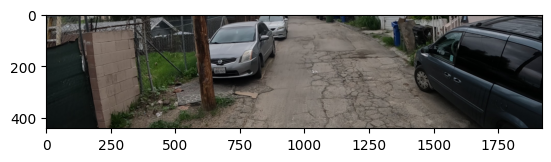

In [16]:
# Crop img to remove the car's dashboard
img = img[:, 500:img.shape[1] - 140, :]


# Print shape of img
print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [17]:
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


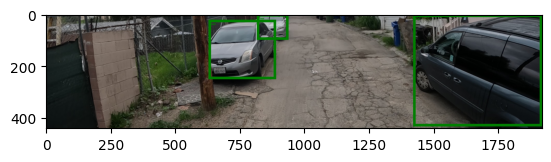

In [18]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

# Step 5: Only select cars in the prediction and visualize the prediction, with green bounding boxes and confidence scores
car_indices = [i for i, label in enumerate(labels) if label == "car"]
car_boxes = prediction["boxes"][car_indices]
car_labels = [labels[i] for i in car_indices]
# car_scores = prediction["scores"][car_indices]
# car_labels_with_scores = [f"{label} {score:.2f}" for label, score in zip(car_labels, car_scores)]

box = draw_bounding_boxes(img, boxes=car_boxes,
                            labels=car_labels,
                            colors="green",
                            width=10, font_size=30)

im = to_pil_image(box.detach())

# Print output using matplotlib
plt.imshow(box.permute(1, 2, 0))


In [19]:
# Get bounding box coordinates
print(prediction["boxes"])

print(prediction["scores"])

print(len(prediction["scores"]))

tensor([[1.4217e+03, 2.6301e+00, 1.9200e+03, 4.3365e+02],
        [6.2913e+02, 2.2023e+01, 8.9072e+02, 2.5133e+02],
        [8.1683e+02, 7.4446e-01, 9.3887e+02, 9.9021e+01]],
       grad_fn=<StackBackward0>)
tensor([0.9984, 0.9960, 0.9943], grad_fn=<IndexBackward0>)
3


In [20]:

# Create dataframe with img and bounding box coordinates and confidence score
df = pd.DataFrame(columns=['img', 'x1', 'y1', 'x2', 'y2', 'confidence_score'])

# Fill in dataframe with img and bounding box coordinates and number of cars and confidence score
for i in range(len(prediction["scores"])):
    df.loc[i] = [image_path, float(prediction["boxes"].detach()[i][0]), float(prediction["boxes"].detach()[i][1]), float(prediction["boxes"].detach()[i][2]), float(prediction["boxes"].detach()[i][3]), float(prediction["scores"].detach()[i])]

# Print dataframe
df


,img,x1,y1,x2,y2,confidence_score
0,/Volumes/JC SSD/SRILab Data/GoPro Frames/frame...,1421.696045,2.630119,1920.000000,433.653473,0.998373
1,/Volumes/JC SSD/SRILab Data/GoPro Frames/frame...,629.126587,22.023277,890.715454,251.334641,0.995958
2,/Volumes/JC SSD/SRILab Data/GoPro Frames/frame...,816.827209,0.744458,938.867493,99.020576,0.994289


In [45]:
frames = pd.read_csv('/Users/junwonchoi/Desktop/SRILab/parked_cars_road_classification/data/frames.csv')

frames

,image_name,timestamp
0,frame1.0.jpg,0.000000
1,frame5.0.jpg,133.466667
2,frame9.0.jpg,266.933333
3,frame13.0.jpg,400.400000
4,frame17.0.jpg,533.866667
...,...,...
4985,frame19941.0.jpg,665331.333333
4986,frame19945.0.jpg,665464.800000
4987,frame19949.0.jpg,665598.266667
4988,frame19953.0.jpg,665731.733333


In [46]:
# Use the above code to create a function that takes in a folder of images and outputs a dataframe with img and bounding box coordinates and confidence score

# Function to get bounding box coordinates and confidence score
def get_bounding_box_and_confidence_score(image_path):
    img = read_image(image_path)
    img = img[:, 500:img.shape[1] - 140, :]
    batch = [preprocess(img)]
    prediction = model(batch)[0]
    labels = [weights.meta["categories"][i] for i in prediction["labels"]]
    car_indices = [i for i, label in enumerate(labels) if label == "car"]
    car_boxes = prediction["boxes"][car_indices]
    car_labels = [labels[i] for i in car_indices]
    df = pd.DataFrame(columns=['img', 'x1', 'y1', 'x2', 'y2', 'confidence_score'])
    for i in range(len(prediction["scores"])):
        df.loc[i] = [image_path, float(prediction["boxes"].detach()[i][0]), float(prediction["boxes"].detach()[i][1]), float(prediction["boxes"].detach()[i][2]), float(prediction["boxes"].detach()[i][3]), float(prediction["scores"].detach()[i])]
    return df


# Function to get bounding box coordinates and confidence score for all images in a folder, with customizable sequence of images (e.g. first 100)
def get_bounding_box_and_confidence_score_for_all_images_in_folder(frames_csv, folder_path, start, end):

    # Read in csv
    frames = pd.read_csv(frames_csv)

    df = pd.DataFrame(columns=['img', 'x1', 'y1', 'x2', 'y2', 'confidence_score'])
    for i in range(start, end):
        # Get image path
        image_path = folder_path + frames['image_name'][i]

        box_score_list = [get_bounding_box_and_confidence_score(image_path)]
        df = pd.concat(box_score_list, ignore_index=True)

    return df


In [47]:
# Get bounding box coordinates and confidence score for all images in a folder
df = get_bounding_box_and_confidence_score_for_all_images_in_folder('/Users/junwonchoi/Desktop/SRILab/parked_cars_road_classification/data/frames.csv', '/Volumes/JC SSD/SRILab Data/GoPro Frames', 0, 100)

# Print dataframe
df

RuntimeError: [Errno 2] No such file or directory: '/Volumes/JC SSD/SRILab Data/GoPro Framesframe1.0.jpg'